In [8]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
matplotlib.rcParams['pdf.fonttype'] = 42
import datetime

In [2]:
def to_onehot(x, n):
    x_onehot = np.zeros((len(x), n), dtype=np.int64)
    for i in range(len(x)):
        x_onehot[i, x[i]] = 1
    return x_onehot

In [3]:
def corr_finder(hidden_all, test_trials):
    hidden_all = hidden_all.detach().numpy()
    
    ind0 = np.where(test_trials == 0)[0]
    ind1 = np.where(test_trials == 1)[0]
    
    total0 = []
    for i in ind0:
        total0.append(hidden_all[i*tr_len:(i+1)*tr_len, :])
    
    total1 = []
    for i in ind1:
        total1.append(hidden_all[i*tr_len:(i+1)*tr_len, :])
    
    mean0 = np.array(total0).mean(0)
    mean1 = np.array(total1).mean(0)
    
    cross_corr = np.corrcoef(mean0, mean1)[:tr_len, tr_len:]
    
    return cross_corr

In [4]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))


    def forward(self, x, hidden):

        feedforward_input = (x @ torch.transpose(self.W_ih, 0, 1))
        recurrent_input = (hidden @ torch.transpose(self.W_hh, 0, 1))
        
        ## RelU activation function
        new_hidden = torch.relu(feedforward_input+recurrent_input)
        
        return new_hidden

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn_cell = RNNCell(input_size, hidden_size)
        nn.init.kaiming_uniform_(self.rnn_cell.W_ih) 
        nn.init.orthogonal_(self.rnn_cell.W_hh)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size, bias=False)
        nn.init.kaiming_uniform_(self.fc.weight) 
        

    def forward(self, x):
        # Initialize hidden state
        hidden_state = torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)

        hidden_state[0,:] = self.rnn_cell(x[0, :], torch.zeros(rnn.rnn_cell.hidden_size, dtype=x.dtype, device=x.device))

        for t in range(1,x.size(0)):

            hidden_state[t,:] = self.rnn_cell(x[t, :], hidden_state[t-1,:].clone())
  
        out = self.fc(hidden_state)
        
        return out, hidden_state

In [5]:
reward = 6
trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,reward,1,1,1,5,5,1,1,0])
trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,reward,1,1,0])



num_trials = 40
num_trials_train = 20
tr_len = len(trial1x)
OBS = len(np.unique(np.concatenate((trial1x, trial2x))))
input_size = OBS
hidden_size = 200
output_size = OBS


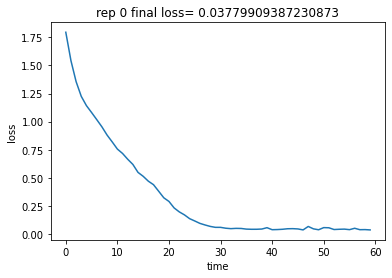

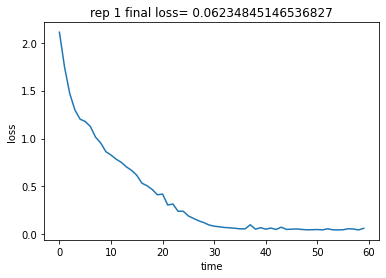

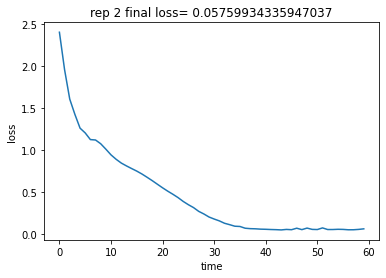

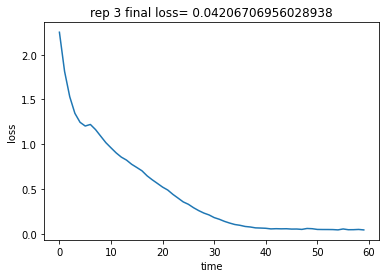

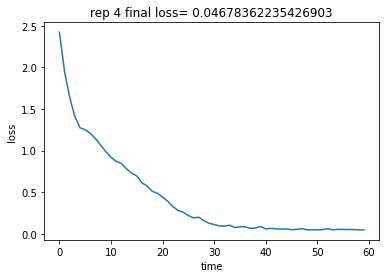

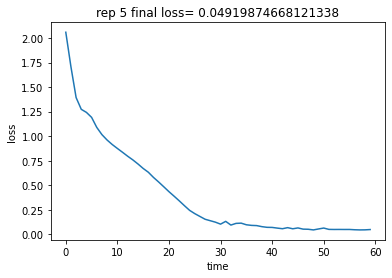

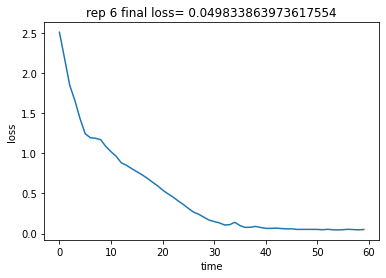

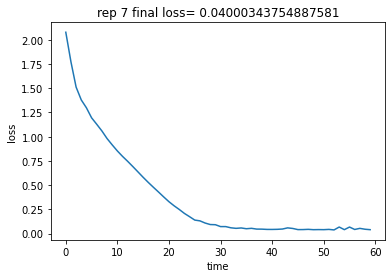

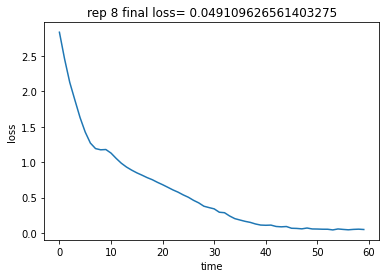

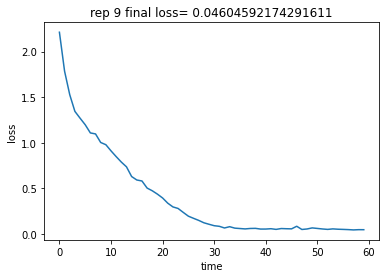

In [6]:
tot_rep = 10
tot_epoch = 60 ##200
save_each = 1
random_seeds = np.arange(0,10)
loss_all = np.zeros((tot_rep, int(tot_epoch/save_each)))
corr_curve = np.zeros((tot_rep, int(tot_epoch/save_each), tr_len, tr_len))
accuracy_curve_all_test= np.zeros((tot_rep, int(tot_epoch/save_each)))


#decorrelation_values = np.zeros((tot_rep, len(correlation_matrices_1), int(tot_epoch/save_each)))
end_times = np.zeros(tot_rep)


for rep in range(0, tot_rep):
    
    torch.manual_seed(random_seeds[rep])
    np.random.seed(random_seeds[rep])
    
    rnn = RNN(input_size, hidden_size)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn.parameters())

    for epoch in range(tot_epoch):
        
        found_trials = False
        while found_trials == False:
            trials = np.random.choice(2, num_trials)
            if np.sum(trials[:-1]==1)>1 and np.sum(trials[:-1]==0)>1:
                found_trials = True
        x = np.zeros(num_trials*tr_len, dtype=np.int64)

        for trial in range(len(trials)):
            if trials[trial] == 0:
                x[trial*tr_len: (trial+1)*tr_len] = trial1x
            else:
                x[trial*tr_len: (trial+1)*tr_len] = trial2x


        x = to_onehot(x, OBS)

        train_x = torch.tensor(x[0:num_trials_train*tr_len], dtype = torch.float32)
        test_x = torch.tensor(x[num_trials_train*tr_len:], dtype = torch.float32)

        optimizer.zero_grad()
        input_x = train_x[:-1]

        prediction, hidden_all = rnn(input_x)

        loss = loss_func(prediction, train_x[1:].argmax(axis = 1)) 

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
        
        if epoch%save_each ==0:
            test_x = torch.tensor(x[num_trials_train*tr_len:], dtype = torch.float32)
            pred_test,hidden_test = rnn(test_x)
            
            ## compute accuracy for only reward prediction
            actual_reward = np.where(np.argmax(test_x[1:], axis = 1)==reward)
            predicted_reward = np.where(np.argmax(pred_test.detach(), axis = 1)==reward)
            accuracy_curve_all_test[rep, int(epoch/save_each)] = len(np.intersect1d(actual_reward, predicted_reward))/len(actual_reward[0])
            corr_curve[rep, int(epoch/save_each)]= corr_finder(hidden_test, trials[num_trials_train:])
            loss_all[rep, int(epoch/save_each)] = (loss.item())
            # Calculate decorrelation values
            corr_matrix = corr_finder(hidden_test, trials[num_trials_train:])
       
    plt.plot(loss_all[rep])
    plt.title('rep ' + str(rep) + ' final loss= ' + str(loss_all[rep][-1]))
    plt.xlabel('time')
    plt.ylabel('loss')
    plt.show()

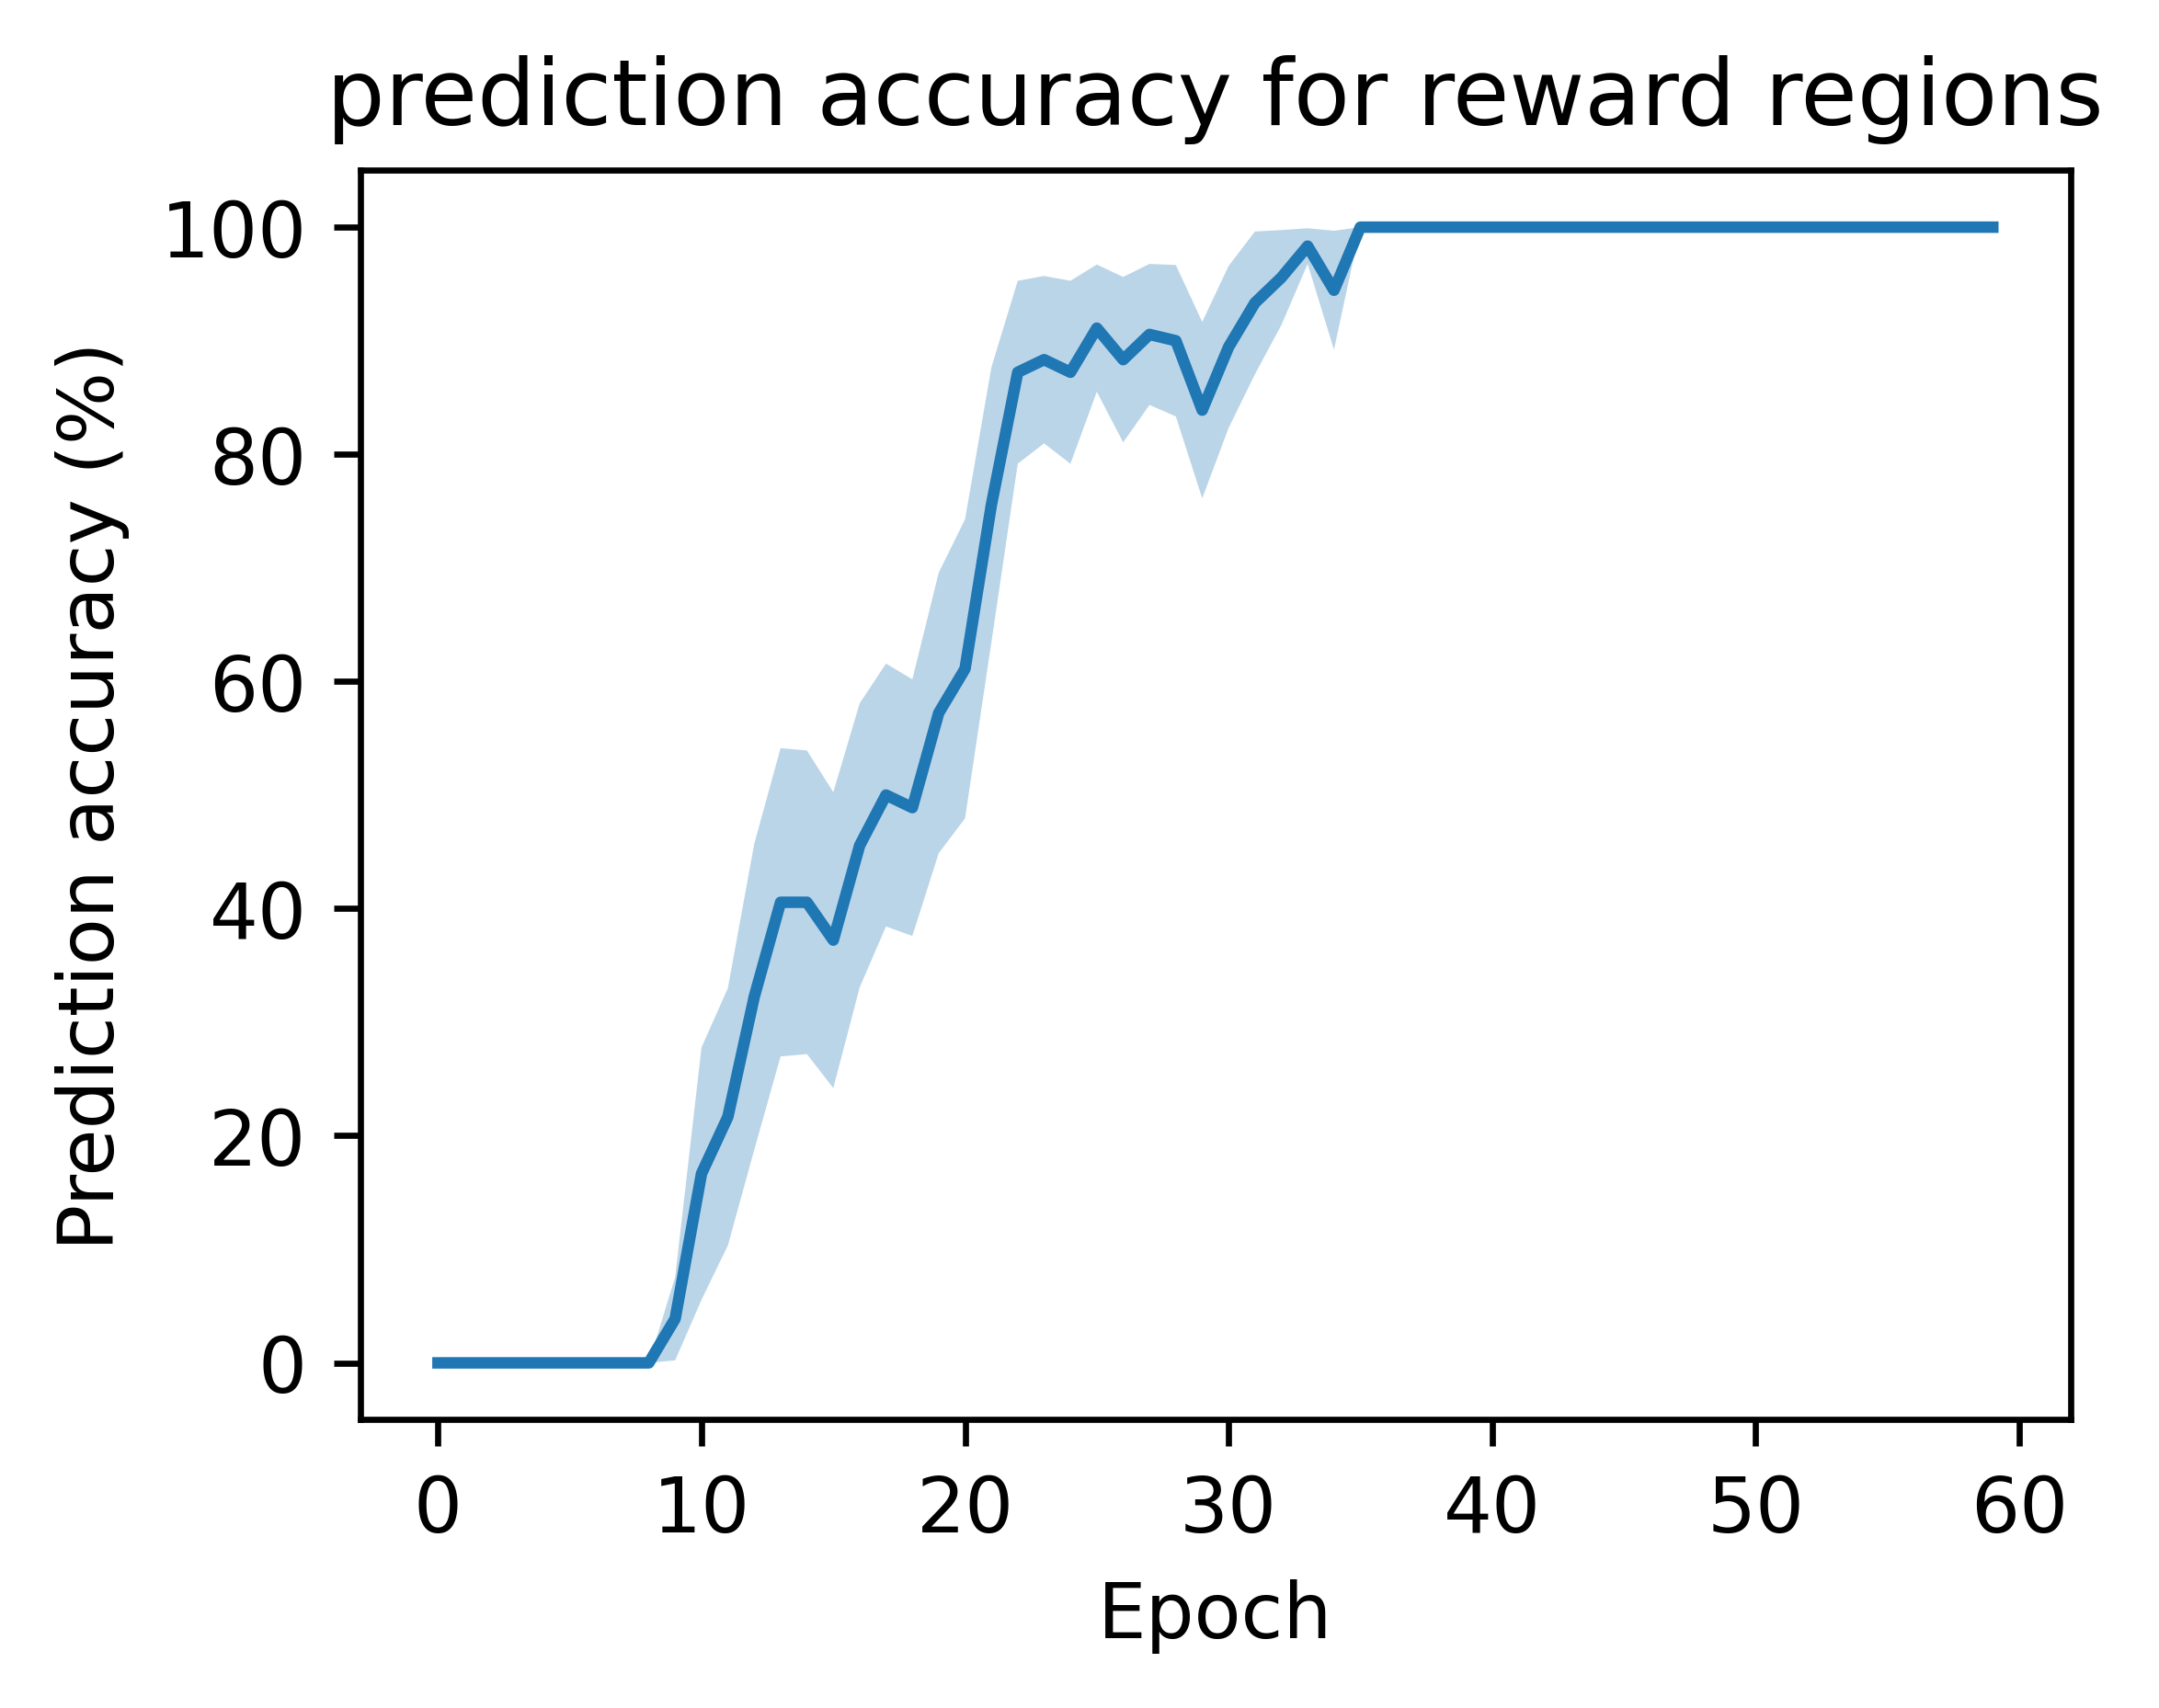

In [9]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

A = np.array(accuracy_curve_all_test[0:rep])  * 100
# Compute the combined mean and standard error of the mean (SEM)
combined_mean = np.mean(A, axis=0)
combined_sem = np.std(A, axis=0) / np.sqrt(A.shape[0])

# Plotting
x = np.arange(A.shape[1])  # Time points

fig, ax = plt.subplots(figsize=(4, 3),dpi = 600)
ax.plot(x, combined_mean, label='Mean')
ax.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)

ax.set_xlabel('Epoch')
ax.set_ylabel('Prediction accuracy (%)')
ax.set_title('prediction accuracy for reward regions')
today = datetime.datetime.now().strftime('%Y_%m_%d')  # get today's date
plt.savefig(f'ReLU_RNN_accuracy_{today}.pdf', format='pdf', dpi=600)
plt.show()

In [10]:
# 1. Extract the last frame for each replicate
last_frames = corr_curve[:, -1, :, :]  # Shape: (10, 23, 23)

# 2. Calculate the mean across replicates
mean_last_frame = np.mean(last_frames, axis=0)  # Shape: (23, 23)

# 3. Calculate the overall mean for the entire covariance matrix
overall_mean = np.mean(last_frames)  # Single scalar value

# 4. Calculate the individual means for each replicate
individual_means = np.mean(last_frames, axis=(1,2))  # Shape: (10,)

# 5. Calculate the SEM
sem = np.std(individual_means) / np.sqrt(10)  # Single scalar value

print(f"Overall mean of the last frame covariance matrix: {overall_mean}")
print(f"SEM: {sem}")
individual_means


Overall mean of the last frame covariance matrix: 0.3997102835630977
SEM: 0.013259997147275153


array([0.35361291, 0.44421162, 0.36907649, 0.43692182, 0.42499193,
       0.45070957, 0.38342588, 0.33965459, 0.44213896, 0.35235906])

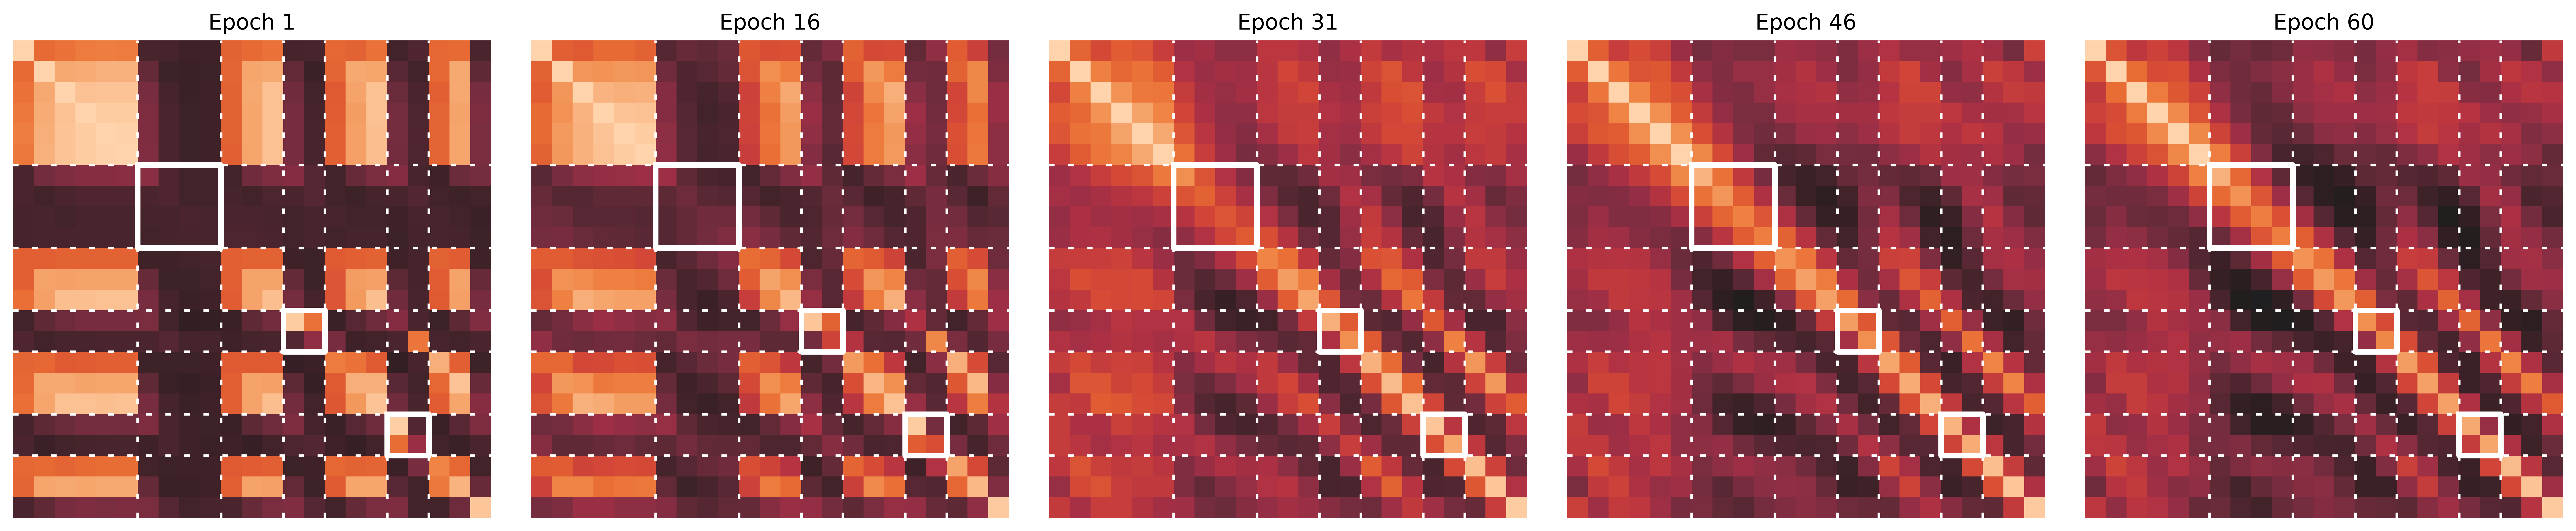

In [12]:
import seaborn as sns

# Calculate mean across replicates
mean_corr_curve = np.mean(corr_curve, axis=0)

# Choose 5 epochs to visualize, including the last one
num_epochs = mean_corr_curve.shape[0]
epochs_to_plot = [0, num_epochs // 4, num_epochs // 2, 3 * num_epochs // 4, num_epochs - 1]

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)

for i, epoch in enumerate(epochs_to_plot):
    sns.heatmap(mean_corr_curve[epoch], cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
    axs[i].set_aspect('equal')  # make each subplot square
    axs[i].set_title(f'Epoch {epoch + 1}')

    # Loop for dotted lines
    for lines in [6, 10, 13, 15, 18, 20]:  
        axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted vertical lines
        axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted horizontal lines

    # Draw square bounding box
    for (low, high) in [(6, 10), (13, 15), (18, 20)]:
        axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white', linewidth=3)  

plt.tight_layout()
today = datetime.datetime.now().strftime('%Y_%m_%d')  # get today's date
plt.savefig(f'ReLU_RNN_corr_plot_{today}.pdf', format='pdf', dpi=600)

plt.show()